In [1]:
import  numpy as np
import scipy.signal as signal
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import *
import pandas as pd
plt.rcParams['text.usetex'] = True

$$ \Sigma^{(i)} := S^{(i)}\rightarrow R_1^{(i)}; R_2^{(i)} \rightarrow I^{(i)} \rightarrow O_1^{(i)}; O_2^{(i)} \rightarrow \theta_{r}^{(i)} \rightarrow \delta \theta^{(i)} \rightarrow $$

$$  \Sigma^{(i)} \rightarrow  \Sigma^{(i+1)}\dots\Sigma^{(n)}$$
where $$\delta\theta^{(n)} = 0$$

#### Source and Receptor

In [24]:
init_params={
    'v' : 10,                    # Wave speed
    'theta_resolution' : 1,     # degrees
    'tolerance' : 0.05,         # Detection threshold
    'r_s' :     50,                # r of source
    'theta_s' : np.deg2rad(270) ,      # theta of source
    'd': 15,       #rescale with r_s*     # radially symmetric receptor positions
    'r1_amp':25,                 # amplitude of outR1
    'r2_amp':25                  # amplitude of outR2
    }
time_params = {
    'dt' : 0.001,                # Time step
    'tmax' : 100,              # Simulation duration
    'pulses' : 10,               # Period between source emissions
    'width' : 100,               # time width of pulse window
}

# Source in polar coordinates
x_s = init_params['r_s'] * np.cos(init_params['theta_s'])
y_s = init_params['r_s'] * np.sin(init_params['theta_s'])
source = np.array([x_s, y_s])
# Receptors (fixed distance from origin along a diameter)
R1cartesian = np.array([init_params['d'], 0])  # theta = pi
R2cartesian = np.array([-init_params['d'],0])  # theta = 0

R1polar = np.array([ init_params['d'], 0])  # theta = pi
R2polar = np.array([ init_params['d'], np.pi])  # theta = 0

init_params.update({'s_position': [x_s,y_s],
                    'r1_position': R1cartesian,
                    'r2_position': R2cartesian,
                    'R1polar': R1polar,
                    'R2polar': R2polar,
                    })

# Time array and output signals
time = np.arange(0, time_params['tmax'], time_params['dt'])
outR1 = np.zeros_like(time)
outR2 = np.zeros_like(time)

# emission, outS = PeriodicEmission(time_params['tmax'], time_params['period'], time_params['dt'])
emission, outS = PeriodicEmissionW(time, time_params)


df = pd.DataFrame({
    'time': time,
    'outS': outS,
    'outR1': outR1,
    'outR2': outR2
})

df2 = ReceptorN(df, emission, init_params)
Vdf = pd.DataFrame({
    'time': time
})


In [25]:
# %run utils.py
# dfPlot(df)

#### Inter Neuron

In [26]:
%run utils.py
interneuron ={
    'V0': -70,  # ground state
    'Vq': -55,  # threshold
    'rft': 1e4,  # refractory phase
    'w1': 6.5,
    'w2': 6.5, 
    'tau': 1,
    'outA': 25,  #amplitude of out current;
    'I1':'outR1',#ID of first current input
    'I2':'outR2'
}

df2, V_I = InterN(df2, interneuron, time_params)
Vdf['V(In)'] =V_I

# dfPlot(df2)

#### Out Neuron

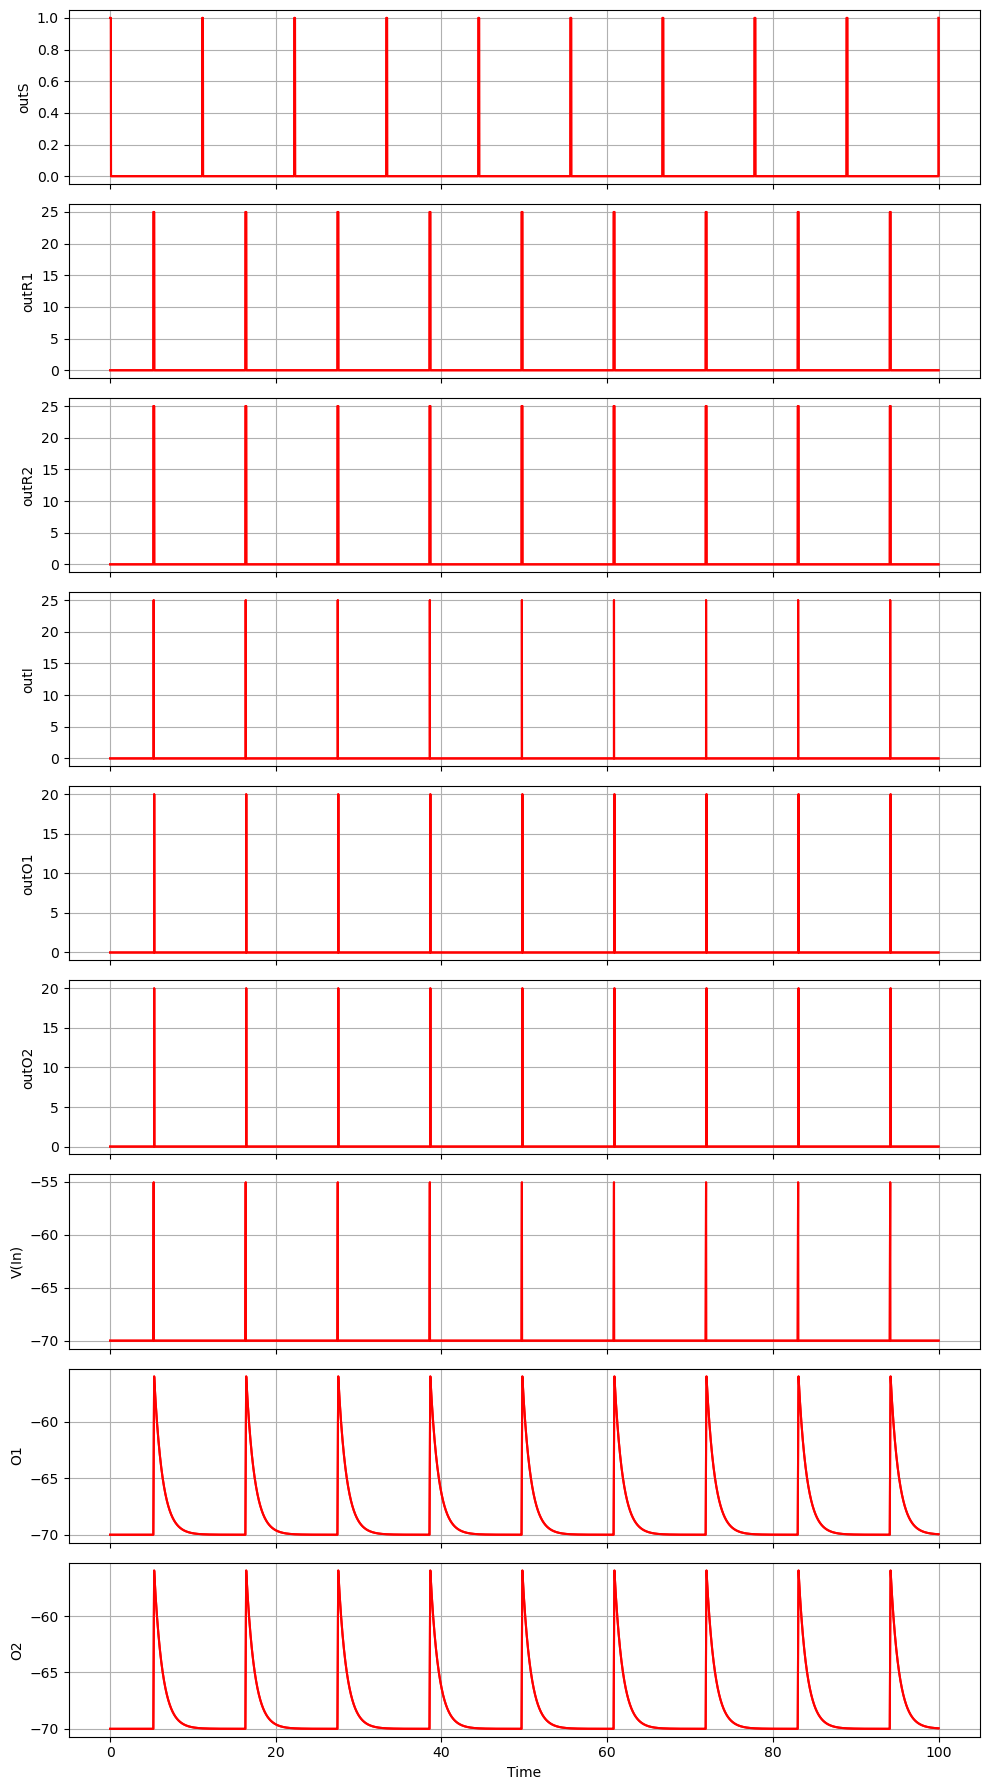

In [27]:
outneuron1 = {
    'id':'O1',
    'V0': -70,  # ground state
    'Vq': -55,  # threshold
    'rft': 2000,  # refractory phase
    'w1': 5,
    'w2': 30,
    'tau': 1,
    'outA': 20,  #amplitude of out current;
    'I1':'outR1',#ID of first current input
    'I2':'outI'
}
outneuron2 = {
    'id':'O2',
    'V0': -70,  # ground state
    'Vq': -55,  # threshold
    'rft': 2000,  # refractory phase
    'w1': 5,
    'w2': 30,
    'tau': 1,
    'outA': 20,  #amplitude of out current;
    'I1':'outR2',#ID of first current input
    'I2':'outI'   
}
%run utils.py

df2, V_O1 = OuterN(df2, outneuron1, time_params)
df2, V_O2 = OuterN(df2, outneuron2, time_params)

Vdf['O1'] = V_O1
Vdf['O2'] = V_O2

combined_df =  pd.concat([df2, Vdf], axis=1)
dfPlot(combined_df)

### $\theta$ updation